In [1]:
import numpy as np
from scipy.signal import butter, filtfilt
from scipy.linalg import expm
from scipy import signal, linalg
import matplotlib.pyplot as plt
import control
import tqdm

To import randomstate from Simo's code

In [2]:
import sys
sys.path.append("../..")

In [3]:
from python.common_utilities import RandomState

Sir wanted me to decrease acceleration to values that are practically possible (4-5 m^2/s)

In [4]:
def gen_ss(thetaVec):
    m = thetaVec[0]
    k = thetaVec[1]
    c = thetaVec[2]

    ndof = 1

    Ac = np.array([[0, 1],
                   [-k/m, -c/m]])

    Bc = np.array([[0],
                   [1 / m]])

    #it works, because C matrix will come from the last 'few' (1 in case od 1 dof) rows of Ac
    #Similarly D from Bc
    getidx = np.arange(ndof, 2 * ndof)
    C = Ac[getidx, :]

    D = Bc[getidx, :]

    return Ac, Bc, C, D


In [18]:


ndof = 1
dt = 0.01  # sampling period
fs = 1 / dt
T = 10  # final time
t = np.arange(0, T + dt, dt)  # time samples

# force gen.
np.random.seed(19)
utmp = np.random.randn(len(t))
b, a = butter(5, 5 / (fs / 2), 'low')
u = filtfilt(b, a, utmp)
u = u.reshape(1001,1)
true_m = 1
true_k = 100
kappa = np.log(true_k)
true_c = 0.4
#zeta = true_c / (2 * true_m * np.sqrt(true_k / true_m))
true_theta = np.array([true_m, np.exp(kappa), true_c])
Ac, Bc, C, D = gen_ss(true_theta)

# Convert continuous to discrete
Cfull = np.vstack((np.eye(2 * ndof), C))
Dfull = np.array([[0], [0], [1 / true_m]])
sysc = signal.StateSpace(Ac, Bc, Cfull, Dfull)
sysd = sysc.to_discrete(dt)
Ad = sysd.A
Bd = sysd.B

#Ad_analytical = expm(Ac*dt) (Checks out)
#Bd_analyt = np.linalg.solve(Ac, (Ad - np.eye(2 * ndof)) @ Bc)



In [19]:
#True state:
z0 = np.array([0, 0])
tout, output, _ = signal.lsim2(sysc, u, t, X0=z0)


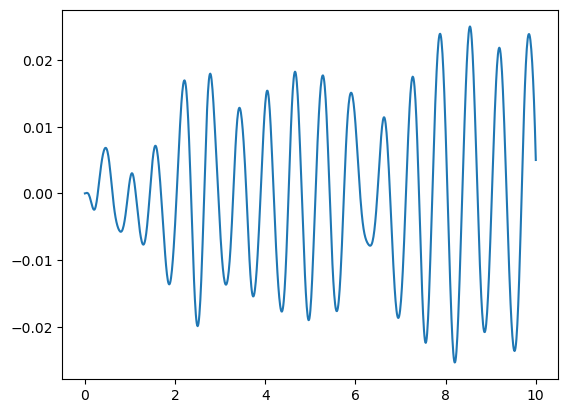

In [20]:
disp = output[:, 0]
plt.plot(t, disp)

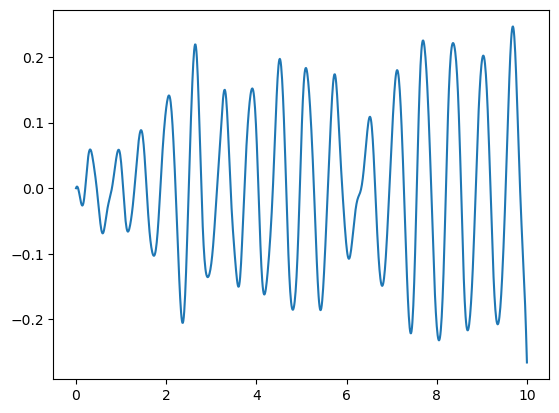

In [21]:
vel = output[:, 1]
plt.plot(t, vel)

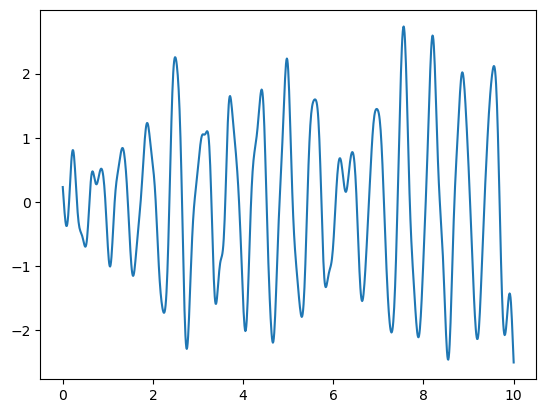

In [22]:
acc = output[:, 2]
plt.plot(t, acc)

In [23]:
#Add Noise
noise_percentage = 10;
noise_std = noise_percentage/100*(np.sqrt(np.mean(acc**2)));
noise = noise_std*np.random.randn(np.size(acc));
y = acc + noise;
y = y.reshape(1001,1)

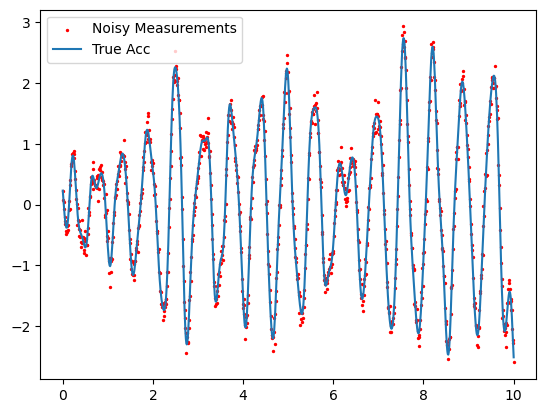

In [24]:
plt.scatter(t,y, label='Noisy Measurements', c='r', s = 2)
plt.plot(t, acc, label = 'True Acc')
plt.legend()

In [25]:
Q = np.diag([1e-10, 1e-10]) #WORKS
#Q = np.diag([0.01, 0.001]) DOESNT WORK
R = np.var(noise) #Set Noise variance to actual noise variance


In [28]:
def get_discrete_mat(m,k,c):
    true_theta = np.array([m, k, c], dtype=object)
    Ac, Bc, C, D = gen_ss(true_theta)
    Cfull = np.vstack((np.eye(2 * ndof), C))
    Dfull = np.array([[0], [0], [1 / true_m]])
    sysc = signal.StateSpace(Ac, Bc, Cfull, Dfull)
    sysd = sysc.to_discrete(dt)
    Ad = sysd.A
    Bd = sysd.B
    
    return Ad, Bd, C, D

In [29]:
def KF(m_0, P_0,Q, R,u, y, k_mean, k_sd, k_curr):
    
    k = np.exp(k_curr)
    A, B, H, D = get_discrete_mat(1,k,0.4)
    steps, N = y.shape

    m = m_0
    P = P_0
    M = m_0.shape[-1]
    #steps, N = observations.shape
    
    kf_m = np.empty((steps, M))
    kf_P = np.empty((steps, M, M))
    #e = prior on kappa(N(k_mean, k_sd))
    e = 0.5*np.log(k_sd) + 0.5*(k_mean-k_curr)**2/(k_sd**2)  #+ .5*np.log(2*np.pi)
    for i in range(steps):    
        m = A @ m + B @ u[i]
        P = A @ P @ A.T + Q
        S = H @ P @ H.T + R
        #K = linalg.solve(S.T, H @ P, assume_a="pos").T
        K = P @ H.T @ linalg.inv(S)
        v = y[i] - (H @ m + D @ u[i])
        m = m + K @ (v)
        P = P - K @ S @ K.T
        
        kf_m[i] = m
        kf_P[i] = P
        e = e + 0.5*np.log(np.sum(np.linalg.eig(2*np.pi*S)[0])) + 0.5*v.T @ linalg.inv(S) @ v
    return e

In [30]:
m_0 = z0
P_0 = np.diag([0.1, 0.1]) 
k_sd = 0.3
k_mean = np.log(90)
k_curr = np.log(100)
KF(m_0, P_0,Q, R,u, y, k_mean, k_sd, k_curr)

-578.5104745774277

In [31]:
en = []
for ar in range(70,200):
    k_sd = 0.3
    k_mean = 3.5
    k_curr = np.log(ar) #k_mean + k_sd*np.random.randn(1)
    m_0 = z0
    P_0 = np.diag([0.1, 0.1]) 
    en.append(KF(m_0, P_0,Q, R,u, y, k_mean, k_sd, k_curr))

Text(0, 0.5, 'Energy')

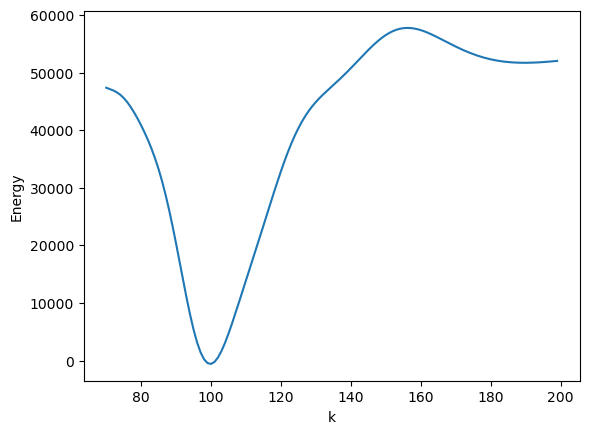

In [32]:
plt.plot(np.arange(70,200),en)
plt.xlabel('k')
plt.ylabel('Energy')

Note: Sir says dont do log(det). Instead use eigen values. 
Since, \
det(A) = prod(eig(A)) \
=> log(det(A)) = sum(log(eig(A)))

In [33]:
def mcmc(k_0, proposal_noise_0, target_acceptance, n_mcmc,u, m_0, P_0, Q, dt, R, y, random_state,k_mean, k_sd,  do_ram=True, do_ram_from=10):
    
    samples = np.empty(n_mcmc)
    i = 0

    k = k_0
    energy = float("inf")
    proposal_noise = proposal_noise_0
    accepted = 0
        
    pbar = tqdm.trange(n_mcmc)
    pbar.set_description(f'MCMC(accepted=0, current(k)={np.exp(k)})')
    for i in pbar:
        new_k = k + proposal_noise * random_state.randn()
        e = KF(m_0, P_0,Q, R,u, y, k_mean, k_sd, new_k)
        acceptance_proba = min(1, np.exp(energy - e))
        u_ = random_state.rand()
        if u_ <= acceptance_proba:
            samples[i] = new_k
            k = new_k
            energy = e
            accepted += 1
            pbar.set_description(f'MCMC(accepted={accepted}, current(k)={np.exp(k)}, proposal_noise={proposal_noise}, energy={energy})')
        else:
            samples[i] = k
            
        if do_ram and (i > do_ram_from):
            nu = 1 / (i**0.9)
            proposal_noise *= np.sqrt(1 + nu * (acceptance_proba - target_acceptance))

    return samples, accepted

In [34]:
k_sd = 0.1
k_mean = 3.5
k_0 = np.log(80)
n_mcmc = 1000
proposal_noise_0 = 0.4
target_acceptance =  0.234 #0.234
random_state = RandomState(1)

samples, accepted = mcmc(k_0, proposal_noise_0, target_acceptance, n_mcmc, u, m_0, P_0, Q, dt, R, y, random_state,k_mean, k_sd,  do_ram=True, do_ram_from=10)

MCMC(accepted=1, current(k)=86.99353199800736, proposal_noise=0.4, energy=28813.83892636667):   0%|          | 4/1000 [00:00<02:30,  6.63it/s]C:\Users\SOBAN\AppData\Local\Temp\ipykernel_2032\2064728047.py:16: RuntimeWarning: overflow encountered in exp
  acceptance_proba = min(1, np.exp(energy - e))
MCMC(accepted=10, current(k)=99.72126990354657, proposal_noise=0.21325946243954552, energy=-531.5561947648785): 100%|██████████| 1000/1000 [02:20<00:00,  7.13it/s]


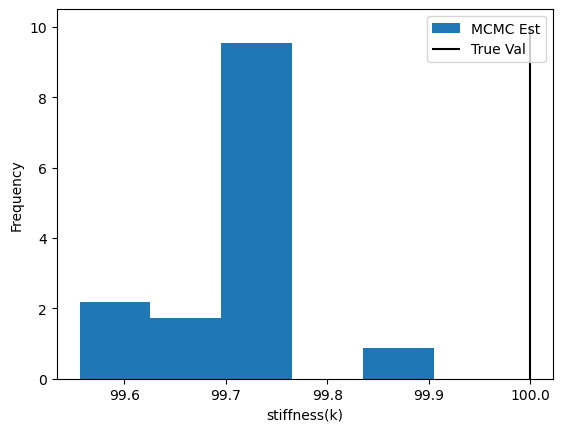

In [44]:
#rejected the first few samples 
samples_k = np.exp(samples[200:])
plt.hist(samples_k, bins= 5, density = True, label = 'MCMC Est')
plt.vlines(100, 0, 10, color = 'black', label = 'True Val')
plt.xlabel("stiffness(k)")

plt.ylabel("Frequency")
plt.legend()

The results are pretty decent.